In [3]:
from labelrepo.projects.participant_demographics import \
        get_participant_demographics
import seaborn as sns

In [4]:
# Load original annotationsb
subgroups = get_participant_demographics()
subgroups.annotator_name.unique()

array(['David_Kennedy', 'Flemming_Kondrup_2', 'Jerome_Dockes',
       'Sean_Moore', 'Xiaotian_Hua', 'calvin_surbey', 'joon_hong',
       'ju-chi_yu', 'kailu_song', 'maximiliane_jousse', 'ross_blair'],
      dtype=object)

### How much overlap & agreement?

/home/zorro/anaconda3/envs/llm-predict/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


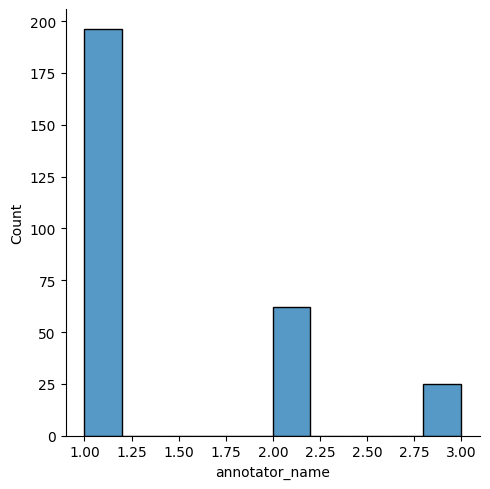

In [5]:
nunique = subgroups.groupby('pmcid')['annotator_name'].nunique()
sns.displot(nunique)

In [6]:
multiple_raters = subgroups[subgroups.pmcid.isin(nunique[nunique > 1].index)]

In [7]:
mean_counts = multiple_raters.groupby(['pmcid', 'annotator_name'])['count'].mean().reset_index()
mean_counts

,pmcid,annotator_name,count
0,2144768,Jerome_Dockes,18.0
1,2144768,kailu_song,20.5
2,2151069,Jerome_Dockes,12.0
3,2151069,Sean_Moore,12.0
4,2151069,kailu_song,12.0
...,...,...,...
194,9230060,Jerome_Dockes,20.0
195,10858222,ju-chi_yu,22.0
196,10858222,ross_blair,22.0
197,10870473,ju-chi_yu,30.0


In [8]:
from itertools import combinations
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

annotators = mean_counts.annotator_name.unique()

ix = dict(zip(annotators, range(len(annotators))))
          
n_overlap = np.zeros((len(annotators), len(annotators)))
corr = np.zeros((len(annotators), len(annotators)))

for a1, a2 in list(combinations(annotators, 2)):
    if ix[a1] == ix[a2]:
        print("WTF")
    # Overlap between a1 and a2
    overlap = mean_counts[(mean_counts.annotator_name == a1) | (mean_counts.annotator_name == a2)]
    overlap = overlap.groupby('pmcid').count()

    # Number of papers where both annotators annotated
    both = overlap[overlap['count'] == 2].index

    a1_counts = mean_counts[mean_counts.annotator_name == a1].set_index('pmcid').loc[both, 'count']
    a2_counts = mean_counts[mean_counts.annotator_name == a2].set_index('pmcid').loc[both, 'count']

    n_overlap[ix[a1], ix[a2]] = len(both)
    n_overlap[ix[a2], ix[a1]] = len(both)

    if len(both) <= 2:
        corr[ix[a1], ix[a2]] = np.nan
        corr[ix[a2], ix[a1]] = np.nan
    else:
        corr[ix[a1], ix[a2]] = pearsonr(a1_counts, a2_counts)[0]
        corr[ix[a2], ix[a1]] = pearsonr(a1_counts, a2_counts)[0]



<Axes: >

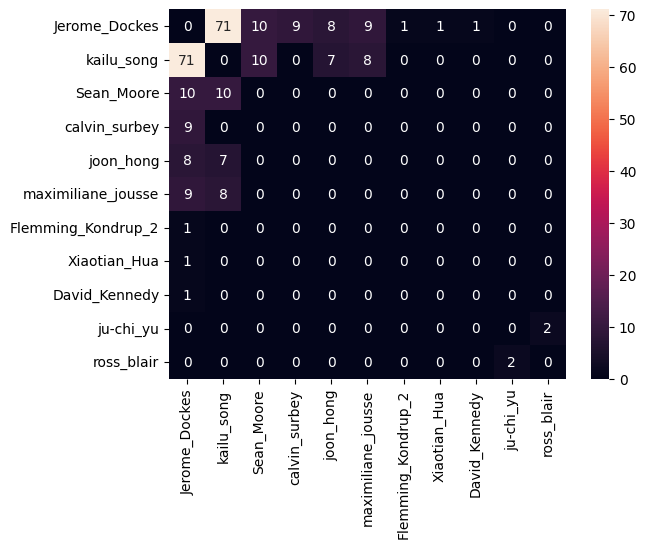

In [9]:

df_n = pd.DataFrame(n_overlap, index = annotators,
                  columns = annotators)
sns.heatmap(df_n, annot=True)

<Axes: >

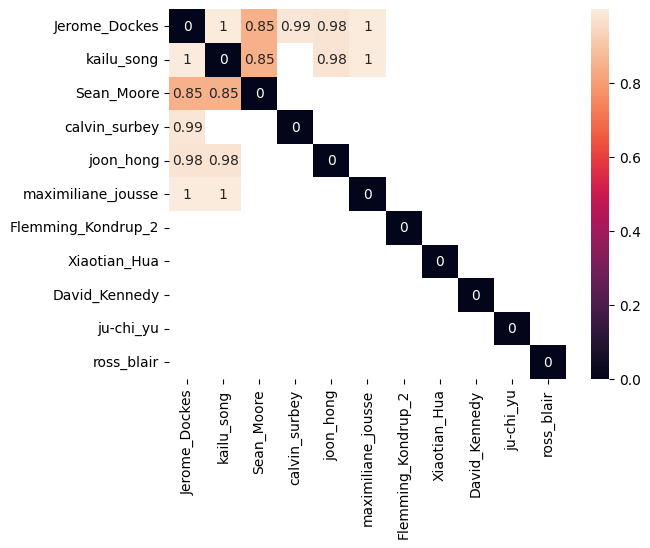

In [10]:

df_cm = pd.DataFrame(corr, index = annotators,
                  columns = annotators)
sns.heatmap(df_cm, annot=True)

Overall, impressively high correlations between annotators.

Assuming Jerome as the best rater, and plus some subjective assesment, we can give the following rater preference:

In [11]:
top_raters = ['Jerome_Dockes', 'kailu_song', 'calvin_surbey', 'joon_hong', 'ju-chi_yu']

### Which studies were rated reliably

In [12]:
stdevs = mean_counts.groupby('pmcid')['count'].std().sort_values()

In [13]:
stdevs[stdevs > 0]

pmcid
4352055      0.353553
3511796      0.353553
5776089      0.577350
7779563      1.154701
3483694      1.527525
2144768      1.767767
2995581      2.121320
2775905      2.828427
5870086      2.886751
6016936      6.928203
3502502      7.778175
4175730      8.082904
6868994     10.606602
9230060     10.606602
5598991     46.476697
6989437     58.689863
4319399    100.409163
3520927    417.193001
Name: count, dtype: float64

In [14]:
# Percent with identical ratings
stdevs[stdevs == 0].shape[0] / stdevs.shape[0]

0.7931034482758621

### Combining data

Based on the rater assesment, choose a rating from the most preferred rater available, and if not then choose randomly

In [15]:
combined = []
for pmcid, group in subgroups.groupby('pmcid'):
    chosen = False
    for rater in top_raters:
        if rater in group.annotator_name.values:
            combined.append(group[group.annotator_name == rater])
            chosen = True
            break

    if not chosen:
        # If not choose rating with most counts
        chosen_rater = group.groupby('annotator_name')['count'].sum().idxmax()
        combined.append(group[group.annotator_name == chosen_rater])

combined = pd.concat(combined)

In [16]:
raters_chosen = combined.groupby('pmcid')['annotator_name'].unique()
raters_chosen = [r[0] for r in raters_chosen]

from collections import Counter

Counter(raters_chosen)

Counter({'Jerome_Dockes': 264,
         'ju-chi_yu': 10,
         'ross_blair': 8,
         'maximiliane_jousse': 1})